In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import astropy.io.fits as fits
import pandas as pd
import healpy as hp
import time
import warnings
import scipy.fftpack
from kymatio import Scattering2D
from kymatio.scattering2d.filter_bank import filter_bank
%matplotlib inline

Definition of the wavelets

In [7]:
#Gabor filter

def gabor_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Gabor filter.
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        freq : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        offset : int, optional
            offset by which the signal starts
        Returns
        -------
        gabor_2d : ndarray
            numpy array of size (M, N)
    """
    gab = np.zeros((M, N), np.complex64)
    [x, y] = np.mgrid[-1*(M//2):(M//2),-1*(N//2):(N//2)]
    arg = -(x**2+y**2)/(2*sigma*sigma) + 1.j * freq*np.sqrt(x**2+y**2)
    gab += np.exp(arg)

    norm_factor = (2 * np.pi * sigma * sigma)
    gab /= norm_factor

    return gab

In [8]:
def morlet_2d(M, N, sigma, freq):
    """
        Computes a symmetric 2D Morlet filter.
        A Morlet filter is the sum of a Gabor filter and a low-pass filter
        to ensure that the sum has exactly zero mean in the temporal domain.
        It is defined by the following formula in space:
        psi(u) = g_{sigma}(u) (e^(i xi^T u) - beta)
        where g_{sigma} is a Gaussian envelope, xi is a frequency and beta is
        the cancelling parameter.
        Parameters
        ----------
        M, N : int
            spatial sizes
        sigma : float
            bandwidth parameter
        xi : float
            central frequency (in [0, pi])
        theta : float
            angle in [0, pi]
        Returns
        -------
        morlet_2d : ndarray
            numpy array of size (M, N)
    """
    wv = gabor_2d(M, N, sigma,  freq)
    wv_modulus = gabor_2d(M, N, sigma, 0)
    K = np.sum(wv) / np.sum(wv_modulus)

    mor = wv - K * wv_modulus
    return mor

Scattering transform

In [9]:
#S1 coefficients

def s1s2coeff(x,J):
    
    s1=np.zeros(J)
    s2=np.zeros((J,J))
    M=x.shape[0]
    N=x.shape[1]
    for j1 in range(J):
        
        sigma1=0.8*2**j1
        freq1=(3*np.pi)/(4.*2**j1)
        
        mor1=morlet_2d(M, N, sigma1, freq1)
        phi1=gabor_2d(M,N,sigma1,0)
        mor1fft=np.real(np.fft.fft2(np.fft.fftshift(mor1)))
        phi1fft=np.real(np.fft.fft2(np.fft.fftshift(phi1)))
        
        U0=np.fft.fft2(x)
        U1=U0*mor1fft
        U1=np.fft.ifft2(U1)
        U1=np.abs(U1)
        U1=np.fft.fft2(U1)
        S1=U1*phi1fft
        S1=np.real(np.fft.ifft2(S1))
        S1=S1.mean()
        s1[j1]=S1
        
        for j2 in range(J):
            
            sigma2=0.8*2**j2
            freq2=(3*np.pi)/(4.*2**j2)
            
            mor2=morlet_2d(M, N, sigma2, freq2)
            phi2=gabor_2d(M,N,sigma2,0)
            mor2fft=np.real(np.fft.fft2(np.fft.fftshift(mor2)))
            phi2fft=np.real(np.fft.fft2(np.fft.fftshift(phi2)))
            
            U2=U1*mor2fft
            U2=np.fft.ifft2(U2)
            U2=np.abs(U2)
            U2=np.fft.fft2(U2)
            S2=U2*phi2fft
            S2=np.real(np.fft.ifft2(S2))
            S2=S2.mean()
            s2[j1][j2]=S2
            
    
    return s1,s2

Input power spectrum

<ipython-input-10-56757b85c7c2>:6: RuntimeWarning: divide by zero encountered in true_divide
  ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)


Text(0, 0.5, '$ln(D_l)$')

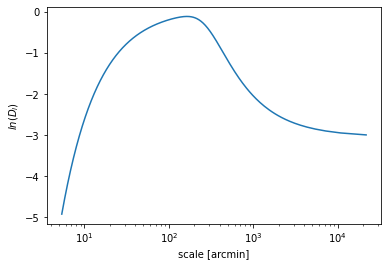

In [10]:
lmax=4000
ell=np.arange(0,lmax+1)

dl=1/(np.exp((60-ell)/20)+np.exp((ell-60)/800))

ellsc=21600/ell # scale = 360/ell (deg) = 21600/ell (arcmin)
ellsc=ellsc[::-1]

fdl=dl[::-1]

plt.plot(ellsc,np.log(fdl))
plt.xlabel('scale [arcmin]')
plt.xscale('log')
plt.ylabel('$ln(D_l)$')

Making a flat sky map for the power spectrum

In [12]:
## variables to set up the size of the map
N = 2**9  # this is the number of pixels in a linear dimension
pix_size  = 2 # size of a pixel in arcminutes

X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees

seed = 589
np.random.seed(seed)

def make_map(N,pix_size,ell,Dl): 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    # convert Dl to Cl
    Cl = Dl * 2 * np.pi / (ell*(ell+1.))
    Cl[0] = 0. 
    Cl[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    Cl_expanded = np.zeros(int(ell2d.max())+1)
    
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    Cl_expanded[0:(Cl.size)] = Cl # fill in the Cls until the max of the Cl vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CL2d = Cl_expanded[ell2d.astype(int)]         
    
    # now make a realization of the given power spectrum in real space
    random_array = np.random.normal(0,1,(N,N))
    FT_random_array = np.fft.fft2(random_array) # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CL2d) * FT_random_array
    # plt.imshow(np.real(FT_2d))
    
    # move back from ell space to real space
    map_ = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    map_ = map_/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    map_ = np.real(map_)

    ## return the map
    return(map_)
  ###############################

def Plot_Map(Map_to_Plot,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(5, 5)
    im = plt.imshow(Map_to_Plot, interpolation=None, origin='lower',cmap=cm.YlOrBr)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
#     plt.ylabel('angle $[^\circ]$')
#     plt.xlabel('angle $[^\circ]$')
    
#     plt.savefig('cmbmap1.png',transparent=False)
    plt.show()
    
    return(0)
  ###############################

<ipython-input-12-6980e32e150e>:14: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1.))


map mean: 0.1545180637536597 map rms: 1.5261668817792715


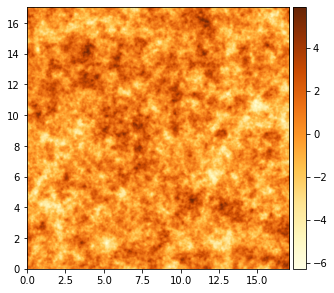

0

In [13]:
fmap= make_map(N,pix_size,ell,dl)
Plot_Map(fmap,X_width,Y_width)

In [14]:
J=8

In [15]:
%%time

cs1,cs2=s1s2coeff(fmap,J)

CPU times: user 10.1 s, sys: 247 ms, total: 10.4 s
Wall time: 10.4 s


Using circularly symmetric filters from the kymatio package

In [16]:
%%time

M=fmap.shape[0]
N=fmap.shape[1]
J=8
L=1
scattering = Scattering2D(J=J, shape=fmap.shape, L=L, max_order=2, frontend='numpy')

CPU times: user 2min 12s, sys: 1.09 s, total: 2min 13s
Wall time: 2min 14s


In [17]:
%%time

coeffs=scattering(fmap)
S=coeffs[0]

CPU times: user 4.01 s, sys: 240 ms, total: 4.25 s
Wall time: 4.25 s


Taking the spatial average of the returned S1 and S2 coefficient maps

In [18]:
S1k=S[1:(1+J*L),:,:]
print(S1k.shape)
S1kav=np.zeros(len(S1k))
for i in range(len(S1k)):
    S1kav[i]=np.mean(S1k[i])

s1k=[]
for i in range(J):
    te=S1kav[i*L:i*L+L] 
    te=np.mean(te)
    s1k.append(te)
print(s1k)

(8, 2, 2)
[0.027358531592074214, 0.05281130724456809, 0.09359193337262259, 0.1283278228190976, 0.14857720364214985, 0.15415745324445215, 0.12072073312917012, 0.0895997880427439]


In [19]:
S2=S[(1+J*L):,:,:]

S2av=np.zeros(len(S2))
for i in range(len(S2)):
    S2av[i]=np.mean(S2[i])

s2l=np.zeros((J,L,J,L))

i=0
for j1 in range(J):
    for th1 in range (L):
        for j2 in range (J):
            for th2 in range (L):
                s2l[j1][th1][j2][th2]=S2av[i]
                i+=1

s2=np.zeros((J,J))

for j1 in range(J):
    for j2 in range(J):
        s2[j1][j2]=s2l[j1,:,j2,:].mean()

In [20]:
res=pix_size
res

2

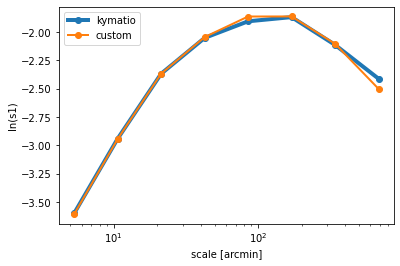

In [21]:
js=np.arange(J)
scale=2**js*((2*res)/0.75)


plt.plot(scale,np.log(s1k),'o-',label='kymatio',lw=4)
plt.plot(scale,np.log(cs1),'o-',label='custom',lw=2)

plt.xlabel('scale [arcmin]')
plt.ylabel('ln(s1)')
plt.legend()
plt.xscale('log')

Text(0, 0.5, 'ln(s2/s1)')

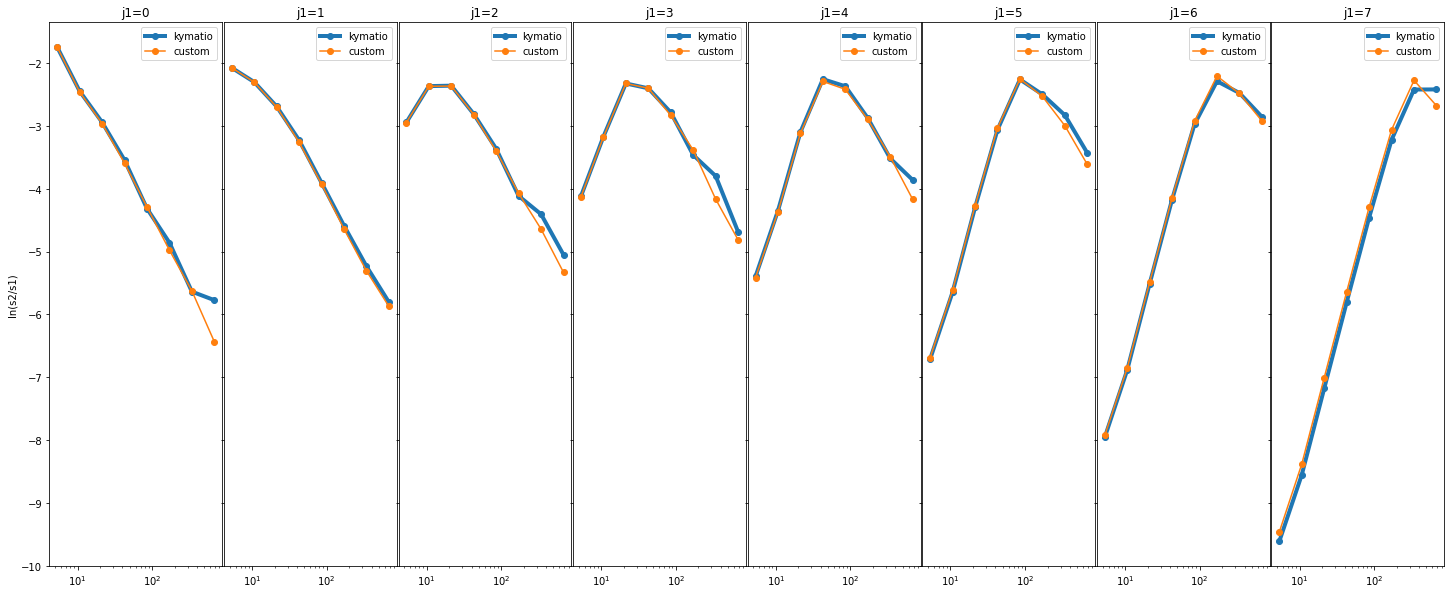

In [22]:
fig, ax = plt.subplots(1, 8,sharey=True,squeeze=True,figsize=(25,10))

ax[0].plot(scale,np.log(s2[0,:]/s1k[0]),'o-',label='kymatio',lw=4)
ax[0].plot(scale,np.log(cs2[0,:]/cs1[0]),'o-',label='custom')
ax[0].set_title('j1=0')
ax[0].set_xscale('log')
ax[0].legend()
ax[1].plot(scale,np.log(s2[1,:]/s1k[1]),'o-',label='kymatio',lw=4)
ax[1].plot(scale,np.log(cs2[1,:]/cs1[1]),'o-',label='custom')
ax[1].set_title('j1=1')
ax[1].set_xscale('log')
ax[1].legend()
ax[2].plot(scale,np.log(s2[2,:]/s1k[2]),'o-',label='kymatio',lw=4)
ax[2].plot(scale,np.log(cs2[2,:]/cs1[2]),'o-',label='custom')
ax[2].set_title('j1=2')
ax[2].set_xscale('log')
ax[2].legend()
ax[3].plot(scale,np.log(s2[3,:]/s1k[3]),'o-',label='kymatio',lw=4)
ax[3].plot(scale,np.log(cs2[3,:]/cs1[3]),'o-',label='custom')
ax[3].set_title('j1=3')
ax[3].set_xscale('log')
ax[3].legend()
ax[4].plot(scale,np.log(s2[4,:]/s1k[4]),'o-',label='kymatio',lw=4)
ax[4].plot(scale,np.log(cs2[4,:]/cs1[4]),'o-',label='custom')
ax[4].set_title('j1=4')
ax[4].set_xscale('log')
ax[4].legend()
ax[5].plot(scale,np.log(s2[5,:]/s1k[5]),'o-',label='kymatio',lw=4)
ax[5].plot(scale,np.log(cs2[5,:]/cs1[5]),'o-',label='custom')
ax[5].set_title('j1=5')
ax[5].set_xscale('log')
ax[5].legend()
ax[6].plot(scale,np.log(s2[6,:]/s1k[6]),'o-',label='kymatio',lw=4)
ax[6].plot(scale,np.log(cs2[6,:]/cs1[6]),'o-',label='custom')
ax[6].set_title('j1=6')
ax[6].set_xscale('log')
ax[6].legend()
ax[7].plot(scale,np.log(s2[7,:]/s1k[7]),'o-',label='kymatio',lw=4)
ax[7].plot(scale,np.log(cs2[7,:]/cs1[7]),'o-',label='custom')
ax[7].set_title('j1=7')
ax[7].set_xscale('log')
ax[7].legend()
plt.subplots_adjust(wspace=0.01,hspace=0.35)
ax[0].set_ylabel("ln(s2/s1)")